In [58]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [108]:
depart_date=time.Time("1977-09-05 00:01", scale="utc").tdb
final_date=time.Time("1983-03-01 00:01", scale="utc").tdb

ephem_earth = Ephem.from_body(Earth, time_range(depart_date,end=final_date),plane=Planes.EARTH_ECLIPTIC)
ephem_jupiter = Ephem.from_body(Jupiter, time_range(depart_date,end=final_date),plane=Planes.EARTH_ECLIPTIC)
ephem_saturn = Ephem.from_body(Saturn, time_range(depart_date,end=final_date),plane=Planes.EARTH_ECLIPTIC)

In [109]:
saturn_orb_ex=Orbit.from_ephem(Sun, ephem_saturn, time.Time("1980-11-12 00:01", scale="utc").tdb)
print(saturn_orb_ex.ecc)

0.054258112246270467


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/numpy/core/function_base.py:277: RuntimeWarning:

overflow encountered in power



Minimum DV required will be 242.8821698275715 m / s
Minimum DV required will be 218.5483714974732 m / s
Minimum DV required will be 194.30166668268578 m / s
Minimum DV required will be 170.14163097721595 m / s
Minimum DV required will be 146.0678427397121 m / s
Minimum DV required will be 122.07988307095445 m / s
Minimum DV required will be 98.17733579152613 m / s
Minimum DV required will be 74.35978741986251 m / s
Minimum DV required will be 50.626827150370914 m / s
Minimum DV required will be 26.978046831798025 m / s
Minimum DV required will be 3.4130409458170847 m / s
Minimum DV required will be 20.068593414209854 m / s
Minimum DV required will be 43.46725656417456 m / s
Minimum DV required will be 66.78334625001433 m / s
Minimum DV required will be 90.01725766848081 m / s
Minimum DV required will be 113.16938348732812 m / s
Minimum DV required will be 136.24011386567332 m / s
Minimum DV required will be 159.2298364739394 m / s
Minimum DV required will be 182.13893651374005 m / s
Mi

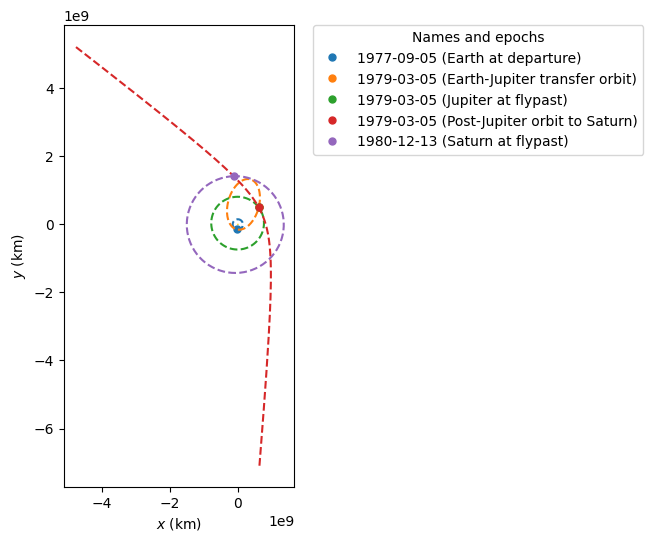

In [115]:
jupiter_transit_time=546*u.day


plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

ss_depart= Orbit.from_ephem(Sun, ephem_earth, depart_date)
ss_arrive= Orbit.from_ephem(Sun, ephem_jupiter, depart_date + jupiter_transit_time)
r_ps=Jupiter.R+np.logspace(700,700000,100)*u.km
# print(len(r_ps))

man_lambert = Maneuver.lambert(ss_depart, ss_arrive)
# starship_orb = Orbit.from_body_ephem(Earth, depart_date)
op_orb,final = ss_depart.apply_maneuver(man_lambert,intermediate=True)       


#search for good gravity assist
lowest_dv=50000*u.m/u.s
best_jupiter_saturn_trans=None
op_orb=op_orb.propagate(jupiter_transit_time)

# for i in range(len(r_ps)):
#     r_p=r_ps[i]
        
r_p=349000*u.km
v_inf_minus=op_orb.rv()[1]-ss_arrive.rv()[1]
speed_inf=np.linalg.norm(v_inf_minus)
flip_sin=1/(1+r_p*speed_inf**2/(Jupiter.k))
angle=2*math.asin(flip_sin)
axis = np.array([0,0, 1.0])          # “mostly z, a bit x”
axis = axis / np.linalg.norm(axis)        # must be unit


rot = scipyRot.from_rotvec(axis*angle)
vel_vector_1 = rot.apply(v_inf_minus.value) * u.km/u.s
out_going_velocity = vel_vector_1 + ss_arrive.rv()[1]
starship_orb = Orbit.from_vectors(Sun, ss_arrive.r, out_going_velocity, epoch=ss_arrive.epoch)
reached_Saturn=False
time_to_Saturn=0
while not reached_Saturn:
    starship_orb=starship_orb.propagate(10*u.day)
    time_to_Saturn += 10*u.day
    if np.linalg.norm(starship_orb.rv()[0]).value > saturn_orb_ex.a.value:
        reached_Saturn=True
        
                  
saturn_arrival_date = depart_date+ jupiter_transit_time + time_to_Saturn
saturn_orb = Orbit.from_ephem(Sun, ephem_saturn, saturn_arrival_date)
for i in range(40):
    saturn_orb = Orbit.from_ephem(Sun, ephem_saturn, saturn_arrival_date+ i*u.day-20*u.day)
    man_lambert_2 = Maneuver.lambert(ss_arrive, saturn_orb)
    trans_orb,final_orb = ss_arrive.apply_maneuver(man_lambert_2,intermediate=True)
    speed_diff = abs(np.linalg.norm((trans_orb.rv()[1]-ss_arrive.rv()[1])) - np.linalg.norm((op_orb.rv()[1]-ss_arrive.rv()[1])))
    print(f"Minimum DV required will be {speed_diff.to(u.m/u.s)}")
    
    

dist = np.linalg.norm(starship_orb.rv()[0] - saturn_orb.rv()[0])
print(f"Closest approach to Saturn at {dist.to(u.au):.2f}")
starship_orb=starship_orb.propagate(-time_to_Saturn)

man_lambert_2 = Maneuver.lambert(ss_arrive, saturn_orb)
trans_orb,final_orb = ss_arrive.apply_maneuver(man_lambert_2,intermediate=True)
#Now we have a speed vector that reaches Saturn
#find gravity assist that leads to said speed vector
print(f"Need to get to {(trans_orb.rv()[1]-ss_arrive.rv()[1]).to(u.km/u.s)} at Jupiter")
print(f"Currently on {op_orb.rv()[1]-ss_arrive.rv()[1]}")
print(f"Assist roughly gets us to {starship_orb.rv()[1]-ss_arrive.rv()[1]} at Jupiter")
speed_diff = abs(np.linalg.norm((trans_orb.rv()[1]-ss_arrive.rv()[1])) - np.linalg.norm((op_orb.rv()[1]-ss_arrive.rv()[1])))
print(f"Minimum DV required will be {speed_diff.to(u.m/u.s)}")

# dv= np.linalg.norm(man_lambert[0][1])
# print(dv)
#         trans_orb,final_2 = starship_orb.apply_maneuver(man_lambert_2,intermediate=True)
#         dv= np.linalg.norm(man_lambert[0][1])
#         if dv < lowest_dv:
#             lowest_dv=dv
#             best_jupiter_saturn_trans,saturn_arriv=trans_orb,saturn_orb
# print(dv)
    
plotter.plot(ss_depart, label="Earth at departure")
plotter.plot(op_orb, label="Earth-Jupiter transfer orbit")
plotter.plot(ss_arrive, label="Jupiter at flypast")
# plotter.plot(best_jupiter_saturn_trans, label="Best Jupiter-Saturn transfer orbit")
# plotter.plot(saturn_arriv, label="Saturn at flypast")
# plotter.plot(starship_orb, label="Jupiter-Saturn transfer orbit")

plotter.plot(trans_orb, label="Post-Jupiter orbit to Saturn")
plotter.plot(saturn_orb, label="Saturn at flypast")

# plotter.plot(best_jupiter_saturn_trans, label="Post-Jupiter orbit to Saturn")
# print("Lowest DV for Earth-Jupiter transfer:", lowest_dv)